In [94]:
from astropy.io import fits
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

In [81]:
filenames = glob('lab4/data/dark/*20s*.FIT')
print(filenames)
in_ = [fits.getdata(file,0) for file in filenames]
data = in_[:][0]
headers = in_[:][1]

['lab4/data/dark\\M29_dark_20s_001.FIT', 'lab4/data/dark\\M29_dark_20s_002.FIT', 'lab4/data/dark\\M29_dark_20s_003.FIT', 'lab4/data/dark\\M29_dark_20s_004.FIT', 'lab4/data/dark\\M29_dark_20s_005.FIT']


In [18]:
print(data)

[array([[1161, 1156, 1167, ..., 1101, 1093, 1087],
       [1165, 1167, 1153, ..., 1071, 1085, 1092],
       [1151, 1152, 1157, ..., 1102, 1087, 1094],
       ..., 
       [1170, 1162, 1155, ..., 1071, 1103, 1088],
       [1189, 1153, 1154, ..., 1102, 1073, 1088],
       [1166, 1156, 1176, ..., 1099, 1079, 1106]], dtype=uint16), array([[1166, 1155, 1158, ..., 1090, 1111, 1069],
       [1148, 1156, 1151, ..., 1094, 1096, 1113],
       [1172, 1164, 1164, ..., 1098, 1093, 1096],
       ..., 
       [1160, 1153, 1157, ..., 1099, 1092, 1114],
       [1177, 1160, 1154, ..., 1092, 1079, 1101],
       [1159, 1156, 1156, ..., 1095, 1087, 1100]], dtype=uint16), array([[1154, 1145, 1150, ..., 1108, 1083, 1079],
       [1183, 1153, 1167, ..., 1090, 1086, 1095],
       [1167, 1155, 1182, ..., 1080, 1101, 1103],
       ..., 
       [1165, 1139, 1176, ..., 1083, 1093, 1089],
       [1162, 1157, 1173, ..., 1093, 1091, 1105],
       [1151, 1166, 1154, ..., 1091, 1109, 1097]], dtype=uint16), array([[1173

In [19]:
median = np.median(data, axis=0)

In [20]:
print(median.shape)

(510, 765)


In [21]:
fifteen = median * .75

In [23]:
fits.writeto('project/data/med_dark_frame_15s.FIT', fifteen)

In [26]:
v_df = pd.read_csv('project/data/Measurements.csv', index_col='slice')

In [35]:
mags = v_df['Source_AMag_T1']
err = v_df['Source_AMag_Err_T1']

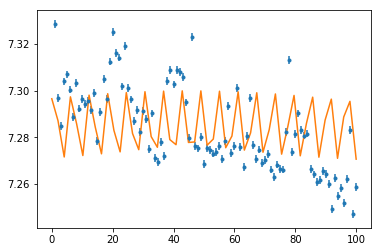

In [128]:
plt.errorbar(v_df.index, mags, yerr=err, fmt='.')
plt.plot(t_fit, y_fit)

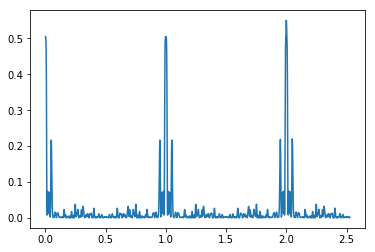

In [68]:
from astropy.stats import LombScargle
frequency, power = LombScargle(v_df.index, mags, err).autopower()
plt.plot(frequency, power)

In [127]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0, 100)
y_fit = LombScargle(t, mags, err).model(t_fit, best_frequency)

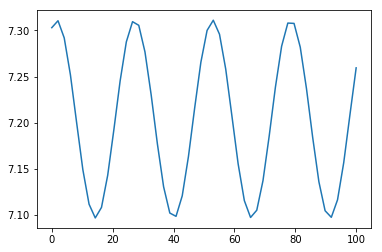

In [73]:
plt.plot(t_fit, y_fit)

In [86]:
filenames = glob('project/data/science/processed/*.FIT')
data = [fits.getdata(file) for file in filenames]
headers = [fits.getheader(file) for file in filenames]

In [110]:
times = [hdr['DATE-OBS'] for hdr in headers]
fmt = '%Y-%m-%dT%H:%M:%S.%f'
times = [dt.datetime.strptime(time, fmt) for time in times]

In [122]:
time_since = []
for i, time in enumerate(times):
    time_since.append((time - times[0]).total_seconds() / 60)
    
t = np.array(time_since)

<Container object of 3 artists>

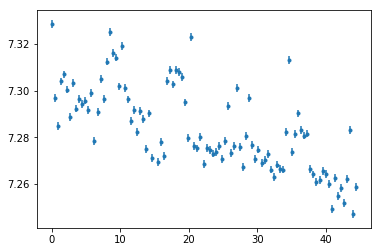

In [123]:
plt.errorbar(t, mags, yerr=err, fmt='.')

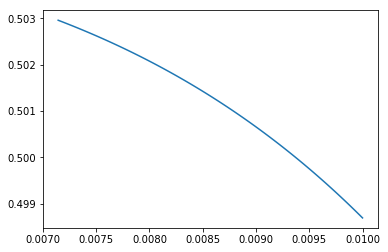

In [140]:
frequency = np.linspace(1/100, 1/140, 100)
power = LombScargle(t, mags, err).power(frequency)
plt.plot(frequency, power)

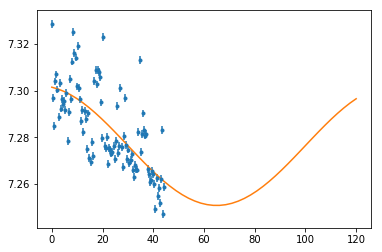

In [142]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0, 120)
y_fit = LombScargle(t, mags, err).model(t_fit, best_frequency)
plt.errorbar(t, mags, yerr=err, fmt='.')
plt.plot(t_fit, y_fit)